In [34]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import sqlite3
import csv
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from wordcloud import WordCloud
import re
import os
from sqlalchemy import create_engine # database connection
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics
from sklearn.metrics import f1_score,precision_score,recall_score
from datetime import datetime
from sklearn.metrics.pairwise import cosine_similarity  
from sklearn.metrics import pairwise_distances
from sklearn.linear_model import SGDClassifier
#import sklearn.externals
#import sklearn.external.joblib as extjoblib
#import joblib
import sklearn.externals
import joblib as joblib
from sklearn.externals import joblib
import scipy.sparse
import pickle

In [35]:
con = sqlite3.connect('processed.db')
processed = pd.read_sql_query("""SELECT * FROM processed""", con)
con.close()

In [36]:
processed = processed.drop(["index"], axis=1)

In [37]:
processed.head()

,source,volume_no,chapter_no,hadith_no,chapter,hadith
0,Sahih Bukhari,1,1,1,Revelation,heard allah apostle saying reward deeds depend...
1,Sahih Bukhari,1,1,2,Revelation,mother faithful believers harith asked allah a...
2,Sahih Bukhari,1,1,3,Revelation,mother faithful believers commencement divine ...
3,Sahih Bukhari,1,1,4,Revelation,explanation statement allah move tongue concer...
4,Sahih Bukhari,1,1,5,Revelation,allah apostle generous people used reach peak ...


In [38]:
labels = {"Revelation" : 0, "Knowledge" : 1, "Belief" : 2}
labels_map = { 0 : "Revelation" , 1 : "Knowledge" , 2 : "Belief"}

In [39]:
processed["chapter"] = processed["chapter"].map(labels)

In [40]:
processed.head(50)

,source,volume_no,chapter_no,hadith_no,chapter,hadith
0,Sahih Bukhari,1,1,1,0,heard allah apostle saying reward deeds depend...
1,Sahih Bukhari,1,1,2,0,mother faithful believers harith asked allah a...
2,Sahih Bukhari,1,1,3,0,mother faithful believers commencement divine ...
3,Sahih Bukhari,1,1,4,0,explanation statement allah move tongue concer...
4,Sahih Bukhari,1,1,5,0,allah apostle generous people used reach peak ...
5,Sahih Bukhari,1,1,6,0,sufyan harb informed heraclius sent messenger ...
6,Sahih Bukhari,1,3,56,1,prophet saying something gathering bedouin cam...
7,Sahih Bukhari,1,3,57,1,prophet remained behind journey joined perform...
8,Sahih Bukhari,1,3,58,1,allah apostle amongst trees tree leaves fall l...
9,Sahih Bukhari,1,3,59,1,prophet amongst trees tree leaves fall like mu...


In [41]:
X = processed.hadith.values
y = processed.chapter.values

In [42]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20,stratify = y)
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.25, stratify = y_train)
X_train.shape, X_test.shape, X_cv.shape

((105,), (36,), (35,))

In [43]:
tfidf = TfidfVectorizer()
X_train = tfidf.fit_transform(X_train)
X_cv = tfidf.transform(X_cv)
X_test = tfidf.transform(X_test)
X_train.shape, X_cv.shape, X_test.shape

((105, 1302), (35, 1302), (36, 1302))

In [44]:
from sklearn.metrics._classification import accuracy_score
score_train = []
score_cv = []
for i in ([1e-9, 1e-8, 1e-7, 1e-6, 0.00001, 0.0001, 0.001, 0.01, 0.1]):
    clf = SGDClassifier(alpha = i, loss = "log", class_weight="balanced", n_jobs=-1)
    clf.fit(X_train, y_train)
    y_predict = clf.predict(X_train)
    y_predict_cv = clf.predict(X_cv)
    score_train.append(accuracy_score(y_train, y_predict))
    score_cv.append(accuracy_score(y_cv, y_predict_cv))

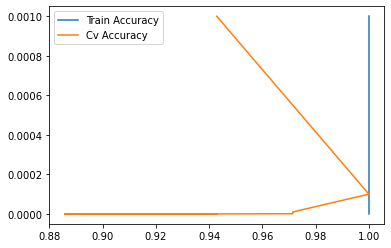

In [45]:
import matplotlib.pyplot as plt
lis = [0.000000001, 0.00000001, 0.0000001, 0.000001, 0.00001, 0.0001, 0.001]
plt.plot(score_train[:-2], lis, label = "Train Accuracy")
plt.plot(score_cv[:-2], lis, label = "Cv Accuracy")
plt.legend()
plt.show()

In [46]:
best_alpha = 1e-7

In [47]:
from sklearn.metrics._classification import confusion_matrix
import seaborn as sns
clf = SGDClassifier(alpha = best_alpha, loss = "log", class_weight="balanced", n_jobs=-1)
clf.fit(X_train, y_train)
y_predict = clf.predict(X_test)
acc = accuracy_score(y_test, y_predict)
cm = confusion_matrix(y_test, y_predict)
print("The Accuracy of model is : ", acc)

The Accuracy of model is :  0.9722222222222222


<AxesSubplot:>

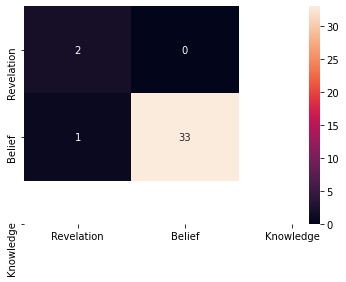

In [48]:
x_ax = ["Revelation", "Belief", "Knowledge"]
y_ax = ["Revelation", "Belief", "Knowledge"]
sns.heatmap(cm, annot = True, fmt="d", xticklabels=x_ax, yticklabels=y_ax)

In [49]:
# Lets See how SVM will perform
score_train = []
score_cv = []
for i in ([1e-9, 1e-8, 1e-7, 1e-6, 0.00001, 0.0001]):
    clf = SGDClassifier(alpha = i, class_weight="balanced", n_jobs=-1)
    clf.fit(X_train, y_train)
    y_predict = clf.predict(X_train)
    y_predict_cv = clf.predict(X_cv)
    score_train.append(accuracy_score(y_train, y_predict))
    score_cv.append(accuracy_score(y_cv, y_predict_cv))

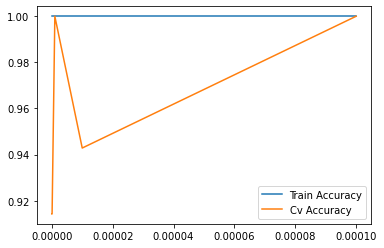

In [50]:
lis = [0.000000001, 0.00000001, 0.0000001, 0.000001, 0.00001, 0.0001]
plt.plot(lis, score_train, label = "Train Accuracy")
plt.plot(lis, score_cv, label = "Cv Accuracy")
plt.legend()
plt.show()

In [51]:
best_alpha = 1e-6

The Accuracy of model is :  0.9166666666666666


<AxesSubplot:>

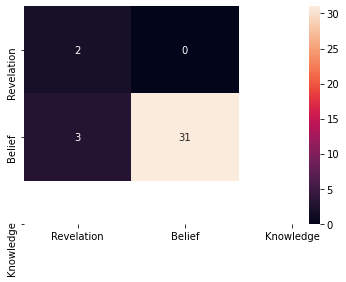

In [52]:
clf = SGDClassifier(alpha = best_alpha, class_weight="balanced", n_jobs=-1)
clf.fit(X_train, y_train)
y_predict = clf.predict(X_test)
acc = accuracy_score(y_test, y_predict)
cm = confusion_matrix(y_test, y_predict)
print("The Accuracy of model is : ", acc)
sns.heatmap(cm, annot = True, fmt="d", xticklabels=x_ax, yticklabels=y_ax)

In [53]:
# CASE OF OVERFITTING
best_alpha = 0.000001

In [54]:
clf = SGDClassifier(alpha = best_alpha, loss = "log", class_weight="balanced", n_jobs=-1)
clf.fit(X_train, y_train)
y_predict = clf.predict(X_test)
acc = accuracy_score(y_test, y_predict)
cm = confusion_matrix(y_test, y_predict)
print("The Accuracy of model is : ", acc)

The Accuracy of model is :  0.9444444444444444


In [55]:
# So lets Take our clf_final which is classifier from LR on Unigram
tfidf = TfidfVectorizer()
data = tfidf.fit_transform(processed.hadith)
data.shape

(176, 1451)

In [56]:
scipy.sparse.save_npz('data.npz', data)

In [57]:
data = scipy.sparse.load_npz('data.npz')

In [58]:
y = processed.chapter.values

In [59]:
clf_final = SGDClassifier(alpha = 1e-7, loss = "log", class_weight="balanced", n_jobs=-1)
clf_final.fit(data, y)

SGDClassifier(alpha=1e-07, class_weight='balanced', loss='log', n_jobs=-1)

In [60]:
#Pre Processing
import nltk
from nltk.corpus import stopwords  # used for preprocessing
nltk.download('stopwords')

#Loading Stopwords into a list
NLTK_stop_words_list=stopwords.words('english')
print(NLTK_stop_words_list)
print("Total numbers of stop words are ")
print(len(NLTK_stop_words_list))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ACER\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [61]:
#Create stopwords list (removing sanad)
custom_stopword_list=['aalimran','aaron','ab','abaalqasim','abahirr','abaina','abal','abalqasim','aban','narrated','narrator',
                      'umar','bin','alkhattab', 'khattab','abu','aisha','etc','ie','us','narrate','narrates','narrating','narration', 
                      'narrations','narrators','said','abbas','aas','abul','aba','amr','abdullah','huraira','ibn','jabir','jubair',
                      'alansari','musa','abul','abulqasim','anas','ubada','assamit','alkhudri','sad','almarur','alahnaf',
                      'qais','albara','azib', 'abaya', 'abbes', 'abd', 'abda', 'abdaddar', 'abdallah', 'abdi', 'abdika', 'abdil', 
                      'abdishams', 'abdkulal', 'abdomen', 'abdominal', 'abdshams', 'abdu', 'abduddal', 'abduhu', 'abduka', 'abdulaziz', 
                      'abdulla', 'abdulmalik', 'abdulmanaf', 'abdulmuttalib', 'abdulmuttlib', 'abdulqais', 'abdultah', 'abdur', 
                      'abdurahman', 'abdurrah', 'abdurrazaq', 'abdurrehman', 'abdushams', 'abdyalail','abqiullah', 'abraham', 'abrahima', 
                      'abida','abidun', 'abiduna', 'abii','abilhakam','abisalama', 'abitalib', 'abjar', 'abl', 'ablda','absentthe', 
                      'abtar', 'abuaddarda', 'abual', 'abualkarish', 'abualmiswar', 'abualqasim', 'abuannadr', 'abuburda', 'abudhar',
                      'abuhuraira', 'abulhakam', 'abulkhair', 'abullqasim', 'abulution','aburafi', 'abusalama','abuwa',
                      'ad', 'adam', 'adba','addabbi', 'addabi', 'addabur', 'addaghina', 'addaghna', 'addail',
                      'addal', 'addan', 'addarawardi', 'addarda', 'addathina', 'addausi','addibbab','adduba', 'addubaib', 'addubba', 
                      'addukh','addukhshun','adhabilqabr', 'adhabilqabri', 'adhabinnar', 'adharbijan', 'adhdhakwani', 'adhdhunuba',
                      'adhfar', 'adhq', 'adhruh','adtahu', 'adullah','aflah','afra','afreet', 'afsa', 'ahajjaj', 'ahban', 'ahdika',
                      'ahmad', 'ahmas', 'ahrnas', 'ahya', 'ahyana', 'aidh', 'aikhail', 'ail', 'aila','ailya','aiman','aimn',
                      'ainain', 'ainattamr','aish', 'aishaa', 'aiyash', 'aiylub', 'aiyuhannabiyu', 'aiyuhannabiyyu', 'aiyyash', 'aizar', 
                      'ajar', 'ajili','ajilihi', 'ajjad', 'ajjuhani', 'ajlan', 'ajwa', 'akbar', 'akhartu', 'akhkhartu', 'akhkhir', 'akhtab', 
                      'akhtaq', 'al', 'al1ah','alaasadi', 'alabbas', 'alabtah', 'alabwa', 'aladawi', 'aladba', 'alahmas', 'alahwal', 'alahwaz',
                      'alaida','alaikas','alajlan', 'alajlani', 'alakbar', 'alakhnas', 'alakhshabain', 'alakwa', 
                      'alala', 'alalaq', 'alalika', 'alalimulhalim', 'alaliya', 'alansarl','alantu', 'alanzi','alansi',
                      'alaqua', 'alaqwa', 'alarai', 'alaraj', 'alaraqa', 'alarat', 'alarj', 'alarqam', 'alart', 'alasadi', 'alasam', 'alasbah', 'alasd', 'alasdi', 'alasfar',
                      'alasghar', 'alashar', 'alashari', 'alashariyin', 'alashariyun', 'alashath', 'alashhal', 'alashira', 'alashiru', 'alashraf', 'alashsari', 'alasi', 'alasia',
                      'alaska', 'alaslaml', 'alaslarrni', 'alasqa', 'alassala', 'alassalat', 'alatira', 'alatma', 'alaudi', 'alaus', 'alauza', 'alawali',
                      'alawamir', 'alawwam', 'alawza', 'alazd', 'alazdi', 'alazim', 'alazl', 'alazlm', 'alazraq', 'albadri', 'albahili', 'albahira',
                      'alallah', 'alamir', 'alamiri', 'alamlak', 'alamri', 'alamu', 'alanaq', 'alanasi', 'alanbar', 'alanbari',
                      'talha','ubaidullah','annuman','bashir','jamra','masud','abi','waqqas','jarir','ziyad',
                      'ilaqa','malik','waqid','allaithi','abdurrahman','bakra','father','wail','muawiya','mahmud',
                      'rabia','alaas','asma','mulaika','alansari','zaid','khalid','aljuhani','burda','alas','ali',
                      'azzubair','salama','ashhubi','um','ammar','aswad','attufail','nafi','nuam','almujmir','tamim',
                      'kuraib','usama','ata','yasar','aiyub','qatada','humran','urwa','uthman','affan','muhammad',
                      'juraij','ubaid','umatiya','seereen','hamza','adi','hatim','almughira','shuba','bakr','yahya',
                      'almazini','juhaifa','shihab','assaib','yazid','thabit','jafar','umaiya','addamri','suwaid',
                      'alnuman','maimuna','amir','numan','qais','binti','bint','mihsin','hudhaifa','wail','sulaiman',
                      'yasar','maimun','qilaba','hazim','mutim','alharith','almuntathir','hisham','hani','talib','umsalama',
                      'ubai','kab','alqasim','alaswad','muadha','zainab','samura','jundub','juhaim','abza','imran','shaqiq',
                      'alamash','husain','alkhuzai','dhar','almunkadir','murra','sahl','mughira','shuba','abdul','aziz','uqba',
                      'shaddad','ishaq','maslama','ibrahim','siyah','dinar','mujahid','bara','itban','attaiyah','alaslami',
                      'ikrima','alkhaulani','hassan','rafi','alsaib','abbad','aun','alubaid','busr','ghailan','azzuhri',
                      'alghifar','alminhal','saiyar','hunaif','almahh','salim','khadij','almuzani','barza','malih',
                      'abulminhal','qurra','humaid','isa','hafsa','mughaffal','almuzani','huwairith','buhaina','rabi',
                      'assaidi','utba','khiyar','muadh','jabal','mamar','marwan','alhakam','mutarrif','musab','wahb','rifaa',
                      'azzuraqi','ata','mabad','warrad','ashshaibani','abis','umm','salmanalfarsi','tawus','salman','umama',
                      'fatima','almundhir','taghlib','hummaid','almiswar','makhrama','shuaib','althaqafi','masruq','namir',
                      'sharik','addahhak','zahdam','raja','alutaridi','umsulaim',
                      'yearold', 'zifar', 'zir', 'ziralhijla', 'zirr', 'zubair', 'zuhair', 'zuhr', 'zuhra', 'zulman', 'zur', 'zuraiq', 'zurara',
                      'zar', 'zaraiq', 'zarnab', 'zanab', 'zanadiqa', 'zanamah','zalamtu', 'zalumtu','yunaqqaththawbulabyadu', 'yunis',
                      'yauq','yassirhu','yarfa','yaminuki', 'yanfa','0','1','10','100','1000','10001','101', 
                      '10178','102','1021','103','104','10day','10th','11','1101','11013','1103','11102','1111','11114',
                      '11115', '1118', '112', '1121', '113', '113rd', '114', '115', '116', '116th', '119', '11th', '12',
                      '120', '12110', '1218', '123032', '128', '12th', '13', '130', '1300', '134', '13th', '14', '140', '1400',
                      '1427', '1428', '1429', '143', '1437', '147', '148', '150', '1500', '153', '156', '157', '158', '1590',
                      '1591', '16', '162', '1629', '165', '166', '168', '17', '17110', '1718', '173', '1756', '1757', '176',
                      '1760', '177', '1778', '1779', '178', '1781', '1785', '17th', '18', '180', '18103', '18105', '182',
                      '183', '185', '1854', '186', '1860', '186082', '1861', '1862', '1863', '1864', '1866', '1870', '1871',
                      '1872', '1873', '1874', '1875', '187577', '1876', '1877', '1878', '187882', '1879', '1880', '1881',
                      '1882', '19', '191', '192', '193', '1939', '195', '1964', '197', '1977', '197778', '197780', '199',
                      '1aij', '1o', '1st', '2', '20', '200', '20000', '2014', '202', '203', '204', '206', '208', '209', '20th',
                      '21', '2102', '2106', '2109', '21104', '212', '2125', '2127', '2136', '2142', '2143', '2144', '2149', '215',
                      '2150', '2158', '2159', '2159160', '2178', '2184', '2187', '2189', '219', '2193', '2195', '2196', '2197',
                      '2198', '2199', '21st', '22', '2201', '221', '2211', '2214', '2219', '222', '2223', '2225', '2232', '2233',
                      '2234', '2235', '2238', '224', '2240', '2249', '2255', '2260', '227', '2273', '228', '2280', '2284', '229',
                      '23', '230', '234', '24', '240', '2411', '241120', '241121', '2415', '242', '2422', '245', '246', '2469',
                      '249', '25', '25168', '253', '2568', '256869', '256870', '2570', '2577', '258', '259', '25th', '260',
                      '261', '26214', '263', '264', '266', '268', '269', '27', '274', '277', '2780', '27th', '281', '283', '2856',
                      '29', '290', '295', '296', '297', '29th', '3', '30', '300', '301', '3013', '302', '3030', '304', '305', '3052',
                      '31', '3113', '3122', '3128', '3134', '3144', '3153', '3172', '3173', '3180', '3186', '3187', '3187188', '3188',
                      '3190', '32', '320', '3217', '322', '3223', '323', '326', '329', '33', '331', '3310', '3321', '3323', '3328',
                      '332829', '3337', '335', '3351', '3353', '336', '3369', '338', '34', '340', '341', '3423', '3449', '3500',
                      '351', '3518', '3522', '354', '355', '356', '357', '36', '360', '3612', '3628', '3638', '364', '365', '37',
                      '37102', '373', '374', '377', '3824', '3830', '3835', '384', '3868', '3886', '391', '392', '393', '3930', '395',
                      '3953', '3967', '397', '3rd', '3s', '4', '40', '4000', '4028', '405', '409', '4102', '411', '412', '4122',
                      '412223', '4127', '4128', '414', '4145', '4159', '4176', '4177', '419', '42', '422', '4223', '423', '4251',
                      '43', '430', '432', '433', '437', '4377', '438', '44', '440', '441', '4410', '441011', '441015', '441016',
                      '4412', '441215', '4415', '4416', '444', '446', '447', '451', '452', '454', '456', '458', '459', '46', '4610',
                      '4624', '465', '469', '47', '4722', '474', '478', '48', '481', '482426', '485', '488', '491', '4913', '492',
                      '4923', '493', '494', '495', '497', '498', '499', '4th', '5', '50', '502', '5030', '5039', '5040', '506', '508', '509',
                      '50th', '5101', '5117', '5117118', '5120121', '513', '514', '518', '52', '521', '523537', '524', '526', '527', '528',
                      '529', '53', '5310', '5318', '532', '533', '5389', '539', '53910', '541', '5415', '542021', '543', '543839', '544',
                      '5445', '544546', '5446', '5451', '546', '547', '550', '551', '555', '557', '558', '56', '5630', '567', '57', '575',
                      '581', '584', '586', '587', '589', '59', '591', '593', '595', '596', '597', '599', '5th', '6', '60', '600', '601',
                      '6010', '601012', '6011', '6012', '603', '608', '6103', '612', '614', '6145', '615', '6158', '616', '617', '620',
                      '621', '6211', '623', '629', '63', '630', '631', '633', '636', '637', '6378', '638', '639', '6414', '645', '648',
                      '65', '652', '656', '657', '658', '659', '66', '6614', '662', '663', '664', '665', '668', '670', '673', '680',
                      '6813', '682', '683', '684', '68491', '685', '68590', '69', '690', '691', '692', '693', '696', '6th', '7', '70',
                      '70000', '700000', '702', '709', '712', '713', '7161', '719', '7199', '72', '721', '7212', '728', '737', '74', '741',
                      '7415', '745', '747', '75', '751', '7516', '751617', '7518', '7519', '753', '755', '759', '76', '760', '762', '77',
                      '778', '78', '781', '783', '793', '794', '795', '796', '797', '7th', '8', '80', '800', '807', '808', '809', '81', '812',
                      '817', '822', '824', '827', '833', '83334', '838', '839', '84', '8478', '848', '85', '865', '866', '87', '871', '872',
                      '88', '8e', '8th', '9', '90', '91', '9112', '9113', '9117119', '9118', '912', '9128', '9128129', '92', '921', '9213',
                      '925', '92510', '9256', '93', '9313', '934', '94', '95', '958', '96', '961', '96123', '9614', '9615', '962', '963',
                      '979', '98', '980', '984', '99', '994', '99596', '9978', '999', '9999', '9th']

In [62]:
final_stopword_list = custom_stopword_list + NLTK_stop_words_list
print(final_stopword_list)
print(len(final_stopword_list))

['aalimran', 'aaron', 'ab', 'abaalqasim', 'abahirr', 'abaina', 'abal', 'abalqasim', 'aban', 'narrated', 'narrator', 'umar', 'bin', 'alkhattab', 'khattab', 'abu', 'aisha', 'etc', 'ie', 'us', 'narrate', 'narrates', 'narrating', 'narration', 'narrations', 'narrators', 'said', 'abbas', 'aas', 'abul', 'aba', 'amr', 'abdullah', 'huraira', 'ibn', 'jabir', 'jubair', 'alansari', 'musa', 'abul', 'abulqasim', 'anas', 'ubada', 'assamit', 'alkhudri', 'sad', 'almarur', 'alahnaf', 'qais', 'albara', 'azib', 'abaya', 'abbes', 'abd', 'abda', 'abdaddar', 'abdallah', 'abdi', 'abdika', 'abdil', 'abdishams', 'abdkulal', 'abdomen', 'abdominal', 'abdshams', 'abdu', 'abduddal', 'abduhu', 'abduka', 'abdulaziz', 'abdulla', 'abdulmalik', 'abdulmanaf', 'abdulmuttalib', 'abdulmuttlib', 'abdulqais', 'abdultah', 'abdur', 'abdurahman', 'abdurrah', 'abdurrazaq', 'abdurrehman', 'abdushams', 'abdyalail', 'abqiullah', 'abraham', 'abrahima', 'abida', 'abidun', 'abiduna', 'abii', 'abilhakam', 'abisalama', 'abitalib', 'abjar

In [63]:
stopwords = set(final_stopword_list)
def process_query(query):
    preprocessed_reviews = []
    sentance = re.sub("\S*\d\S*", "", query).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())
    return preprocessed_reviews

def tfidf_search(query):
    query = process_query(query)
    query_trans = tfidf.transform(query)
    pairwise_dist = pairwise_distances(data, query_trans)
    
    indices = np.argsort(pairwise_dist.flatten())[0:10]
    df_indices = list(processed.index[indices])
    return df_indices


def label(query):
    query = process_query(query)
    query = tfidf.transform(query)
    ans = clf_final.predict(query)
    return labels_map[ans[0]]


def change_query(query):
    tag = label(query)
    return query + " " + tag

In [66]:
def enter_queries(query) : 
    print("The Query is :", query)
    query = change_query(query)
    df_indices = tfidf_search(query)
    print("The Model Interpreted Query by Chapter :", query)
    print("Top Results : ")
    for i in (df_indices):
        print("\nHadith : ", processed.hadith.iloc[i])

In [67]:
query = "reward"
enter_queries(query)

The Query is : reward
The Model Interpreted Query by Chapter : reward Revelation
Top Results : 

Hadith :  heard allah apostle saying reward deeds depends upon intentions every person get reward according intended whoever emigrated worldly benefits woman marry emigration emigrated

Hadith :  heard allah apostle saying reward deeds depends upon intentions every person get reward according intended whoever emigrated worldly benefits woman marry emigration emigrated

Hadith :  allah apostle three persons double reward person people scriptures believed prophet jesus moses believed prophet e embraced islam slave discharges duties allah master master woman slave teaches good manners educates best possible way religion manumits marries

Hadith :  allah apostle three persons double reward person people scriptures believed prophet jesus moses believed prophet e embraced islam slave discharges duties allah master master woman slave teaches good manners educates best possible way religion manumit